In [102]:
import gpxpy
import mplleaflet
import pandas as pd
import numpy as np
from pykalman import KalmanFilter

import matplotlib.pyplot as plt
#plt.rcParams['axes.xmargin'] = 0.1
#plt.rcParams['axes.ymargin'] = 0.1
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
with open('../gpx/3-laender-giro.gpx') as fh:
    gpx_file = gpxpy.parse(fh)
    
segment = gpx_file.tracks[0].segments[0]

### Let's try to correct some unrealistic things like

In [3]:
segment.get_uphill_downhill()

UphillDownhill(uphill=4446.100000000043, downhill=4439.100000000031)

### But we start with a little bit of data wrangling

In [4]:
coords = pd.DataFrame([{'idx': i,
                        'lat': p.latitude, 
                        'lon': p.longitude, 
                        'ele': p.elevation,
                        'time': p.time} for i, p in enumerate(segment.points)])
coords.set_index('time', inplace=True)
coords.head()

,ele,idx,lat,lon
time,,,,
2016-06-26 04:31:27,1343.0,0,46.889062,10.502119
2016-06-26 04:31:28,1343.0,1,46.889062,10.502119
2016-06-26 04:31:29,1343.0,2,46.889062,10.502119
2016-06-26 04:31:30,1344.0,3,46.889065,10.502119
2016-06-26 04:31:31,1345.0,4,46.889068,10.502121


In [5]:
coords.tail()

,ele,idx,lat,lon
time,,,,
2016-06-26 10:49:01.117,1350.0,22627,46.888570,10.502008
2016-06-26 10:49:02.117,1350.0,22628,46.888573,10.502010
2016-06-26 10:49:03.117,1350.0,22629,46.888574,10.502012
2016-06-26 10:49:04.117,1350.0,22630,46.888574,10.502013
2016-06-26 10:49:05.117,1350.0,22631,46.888575,10.502012


### Oh... time interval is not always 1sec, let's do something about that and round to nearest sec

In [6]:
coords.index = np.round(coords.index.astype(np.int64), -9).astype('datetime64[ns]')
coords.tail()

,ele,idx,lat,lon
2016-06-26 10:49:01,1350.0,22627,46.888570,10.502008
2016-06-26 10:49:02,1350.0,22628,46.888573,10.502010
2016-06-26 10:49:03,1350.0,22629,46.888574,10.502012
2016-06-26 10:49:04,1350.0,22630,46.888574,10.502013
2016-06-26 10:49:05,1350.0,22631,46.888575,10.502012


### Do we have signal loss?

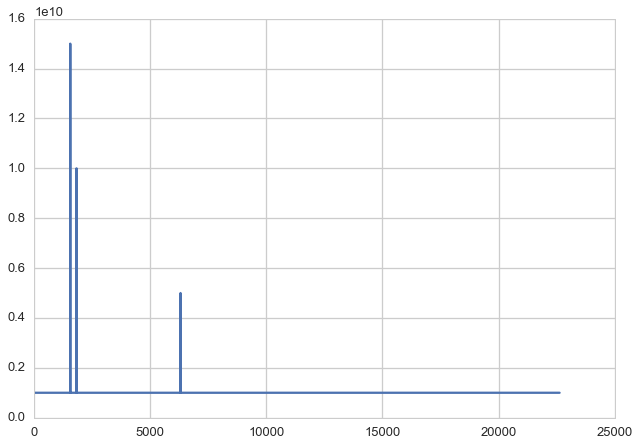

In [7]:
plt.plot(np.diff(coords.index))

### Okay, let's resample with 1 sec intevals and fill up with NaN

In [8]:
coords = coords.resample('1S').asfreq()
coords.loc[coords.ele.isnull()].head()

,ele,idx,lat,lon
2016-06-26 04:57:17,NaN,NaN,NaN,NaN
2016-06-26 04:57:18,NaN,NaN,NaN,NaN
2016-06-26 04:57:19,NaN,NaN,NaN,NaN
2016-06-26 04:57:20,NaN,NaN,NaN,NaN
2016-06-26 04:57:21,NaN,NaN,NaN,NaN


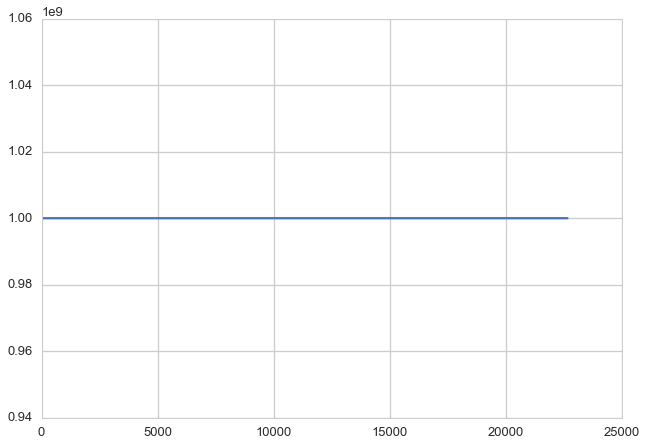

In [9]:
plt.plot(np.diff(coords.index))

### Almost done. Now convert to good old numpy array and mask NaNs

In [10]:
measurements = np.ma.masked_invalid(coords[['lon', 'lat', 'ele']].values)

### So where did I lose the GPS signal?

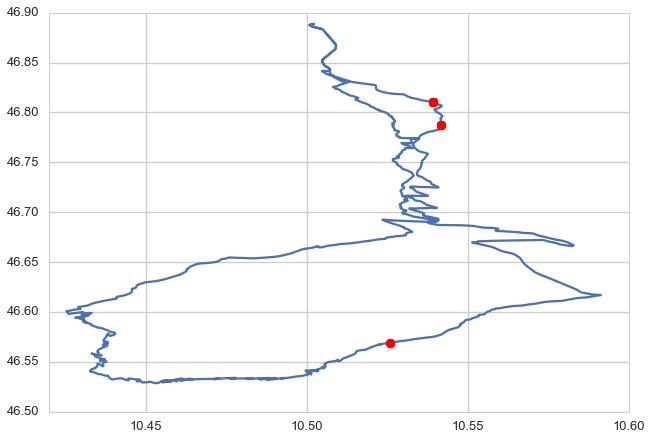

In [11]:
fig = plt.figure()
plt.plot(measurements[:,0], measurements[:,1])
filled_coords = coords.fillna(method='pad').ix[coords.ele.isnull()]
plt.plot(filled_coords['lon'].values, filled_coords['lat'].values, 'ro')

### Let's set up the Kalman Filter

In [153]:
F = np.array([[1, 0, 0, 1, 0, 0],
              [0, 1, 0, 0, 1, 0],
              [0, 0, 1, 0, 0, 1],
              [0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1]])

H = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0]])

initial_state_mean = np.hstack([measurements[0, :], 3*[0]])
initial_state_covariance = np.diag([1e-4, 1e-4, 35, 1e-8, 1e-8, 1e-8])**2

In [154]:
kf = KalmanFilter(transition_matrices=F, 
                  observation_matrices=H, 
                  initial_state_mean=initial_state_mean,
                  initial_state_covariance=initial_state_covariance,
                  em_vars=['transition_covariance', 'observation_covariance'])

In [155]:
kf = kf.em(measurements, n_iter=100)

In [156]:
kf.observation_covariance

array([[  6.02883283e-12,   2.33726528e-13,  -1.82673943e-08],
       [  2.33726557e-13,   5.65362618e-12,  -3.21320198e-10],
       [ -1.82673839e-08,  -3.21324680e-10,   2.90100354e-02]])

In [157]:
kf.transition_covariance

array([[  4.68843132e-11,  -1.06356808e-11,  -4.21620715e-07,
          6.35957077e-11,  -1.92261314e-11,  -7.60310732e-08],
       [ -1.06356712e-11,   4.38171182e-11,   3.18516945e-07,
         -1.78407976e-11,   5.12374333e-11,   7.82653196e-08],
       [ -4.21620675e-07,   3.18516932e-07,   5.13849015e-01,
         -3.11371897e-07,   1.47292088e-07,   1.12312165e-02],
       [  6.35957081e-11,  -1.78408047e-11,  -3.11371925e-07,
          1.26726659e-10,  -3.72470080e-11,  -1.61164368e-07],
       [ -1.92261247e-11,   5.12374331e-11,   1.47292097e-07,
         -3.72469988e-11,   1.02897026e-10,   1.65225216e-07],
       [ -7.60310658e-08,   7.82653207e-08,   1.12312165e-02,
         -1.61164360e-07,   1.65225220e-07,   3.44619348e-02]])

In [88]:
kf.observation_covariance[2,2] = 1000**2
kf.observation_covariance[0,0] = 5**2
kf.observation_covariance[1,1] = 5**2

### Compare now our measurements with a smoothed track

In [138]:
smoothed_state_means, _ = kf.smooth(measurements)

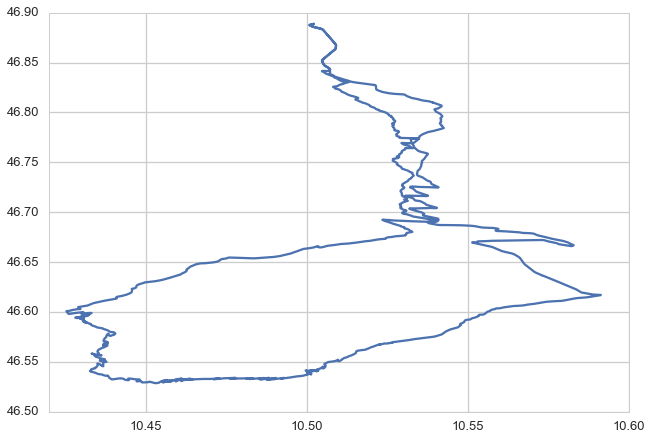

In [148]:
plt.plot(measurements[:,0], measurements[:,1])

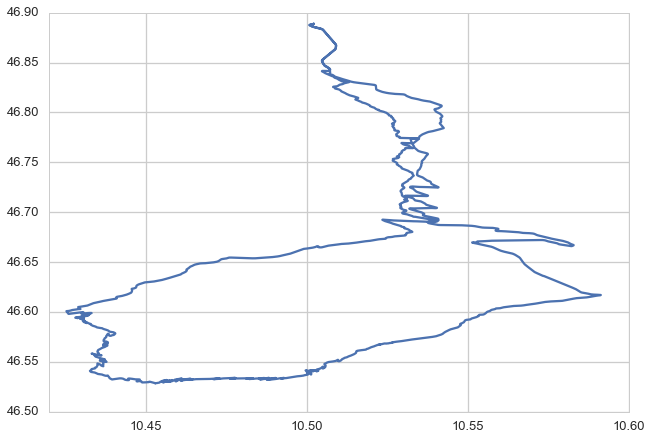

In [149]:
plt.plot(smoothed_state_means[:,0], smoothed_state_means[:,1])

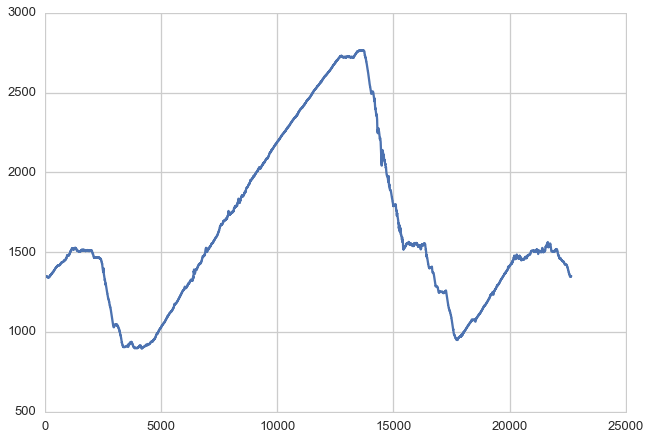

In [150]:
plt.plot(measurements[:,2])

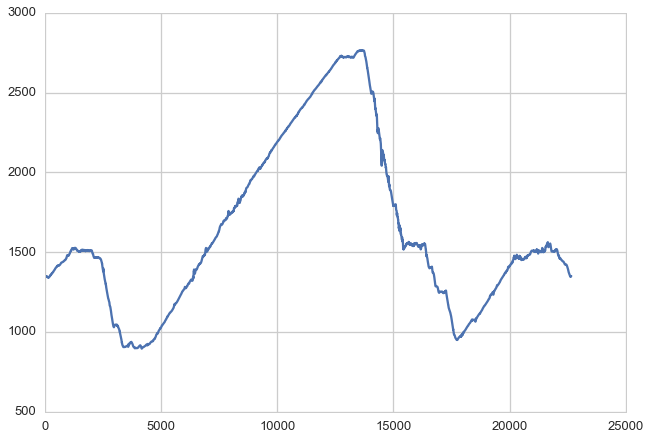

In [151]:
plt.plot(smoothed_state_means[:,2])

### Let's write the smoothed data back into our dataframe and GPX file

In [143]:
coords.ix[:, ['lon', 'lat', 'ele']] = smoothed_state_means[:,:3]
orig_coords = coords.ix[~coords['idx'].isnull()].set_index('idx')

In [144]:
for i, p in enumerate(segment.points):
    p.speed = None
    p.elevation = orig_coords.at[float(i),'ele']
    p.longitude = orig_coords.at[float(i),'lon']
    p.latitude = orig_coords.at[float(i),'lat']

In [152]:
segment.get_uphill_downhill()

UphillDownhill(uphill=4349.8348710827468, downhill=4342.7909416937146)

### Yes, that sounds much more realistic!!! Let's also check the speed

In [97]:
segment.points[0].speed = 0.0
segment.points[-1].speed = 0.0
gpx_file.add_missing_speeds()

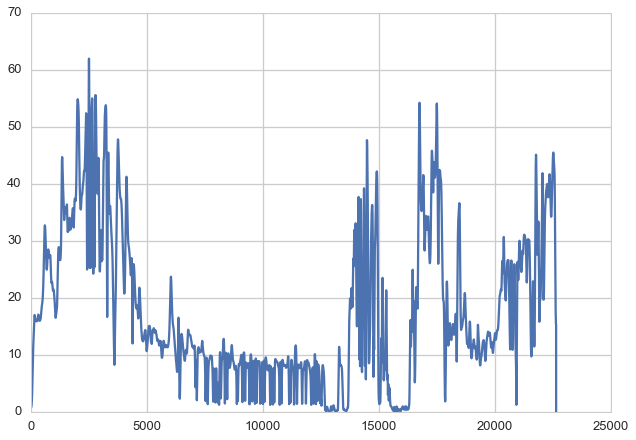

In [98]:
speed = np.array([p.speed for p in segment.points])*3.6
plt.plot(speed)